In [7]:
# imports

import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# load data file located in compass-analysis folder

data_file_path = "../compas-analysis/compas-scores-two-years.csv"

df = pd.read_csv(data_file_path)

In [20]:
# Select features needed for data analysis
analysis_features = [
    'sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
    'juv_other_count', 'priors_count', 'days_b_screening_arrest',
    'c_charge_degree', 'two_year_recid', 'decile_score'
]

df_analysis = df[analysis_features]
print("Features for Data Analysis:\n", df_analysis.head())


# some features are categorical - change them by using one-hot
categorical_cols_analysis = ['sex', 'age_cat', 'c_charge_degree', 'race']

df_analysis_encoded_encoded_encoded = pd.get_dummies(df_analysis, columns=categorical_cols_analysis, drop_first=True)
print("One-Hot Encoded Data Analysis Dataset:\n", df_analysis_encoded.head())

# save this dataframe into a csv file

df_analysis_encoded.to_csv('../compas-analysis/compas-scores-two-years-analysis-encoded.csv')


Features for Data Analysis:
     sex  age          age_cat              race  juv_fel_count  \
0  Male   69  Greater than 45             Other              0   
1  Male   34          25 - 45  African-American              0   
2  Male   24     Less than 25  African-American              0   
3  Male   23     Less than 25  African-American              0   
4  Male   43          25 - 45             Other              0   

   juv_misd_count  juv_other_count  priors_count  days_b_screening_arrest  \
0               0                0             0                     -1.0   
1               0                0             0                     -1.0   
2               0                1             4                     -1.0   
3               1                0             1                      NaN   
4               0                0             2                      NaN   

  c_charge_degree  two_year_recid  decile_score  
0               F               0             1  
1          

In [21]:


# 1. Row and Column Count
print("Dataset Shape:", df_analysis_encoded.shape)

# 2. Column Names
print("Column Names:", df_analysis_encoded.columns.tolist())

# 3. Data Types
print("Data Types:\n", df_analysis_encoded.dtypes)

# 4. Basic Summary Statistics
print("Summary Statistics:\n", df_analysis_encoded.describe())

# 5. Missing Values
print("Missing Values:\n", df_analysis_encoded.isnull().sum())

# 6. Unique Values
print("Unique Values Per Column:\n", df_analysis_encoded.nunique())

# 7. Value Counts for Categorical Fields
categorical_cols = df_analysis_encoded.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"Value Counts for {col}:\n", df[col].value_counts(), "\n")


Dataset Shape: (7214, 17)
Column Names: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'two_year_recid', 'decile_score', 'sex_Male', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'c_charge_degree_M', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']
Data Types:
 age                          int64
juv_fel_count                int64
juv_misd_count               int64
juv_other_count              int64
priors_count                 int64
days_b_screening_arrest    float64
two_year_recid               int64
decile_score                 int64
sex_Male                      bool
age_cat_Greater than 45       bool
age_cat_Less than 25          bool
c_charge_degree_M             bool
race_Asian                    bool
race_Caucasian                bool
race_Hispanic                 bool
race_Native American          bool
race_Other                    bool
dtype: object
Summary Statistics:
        

Class Distribution (two_year_recid):
 two_year_recid
0    0.549348
1    0.450652
Name: proportion, dtype: float64


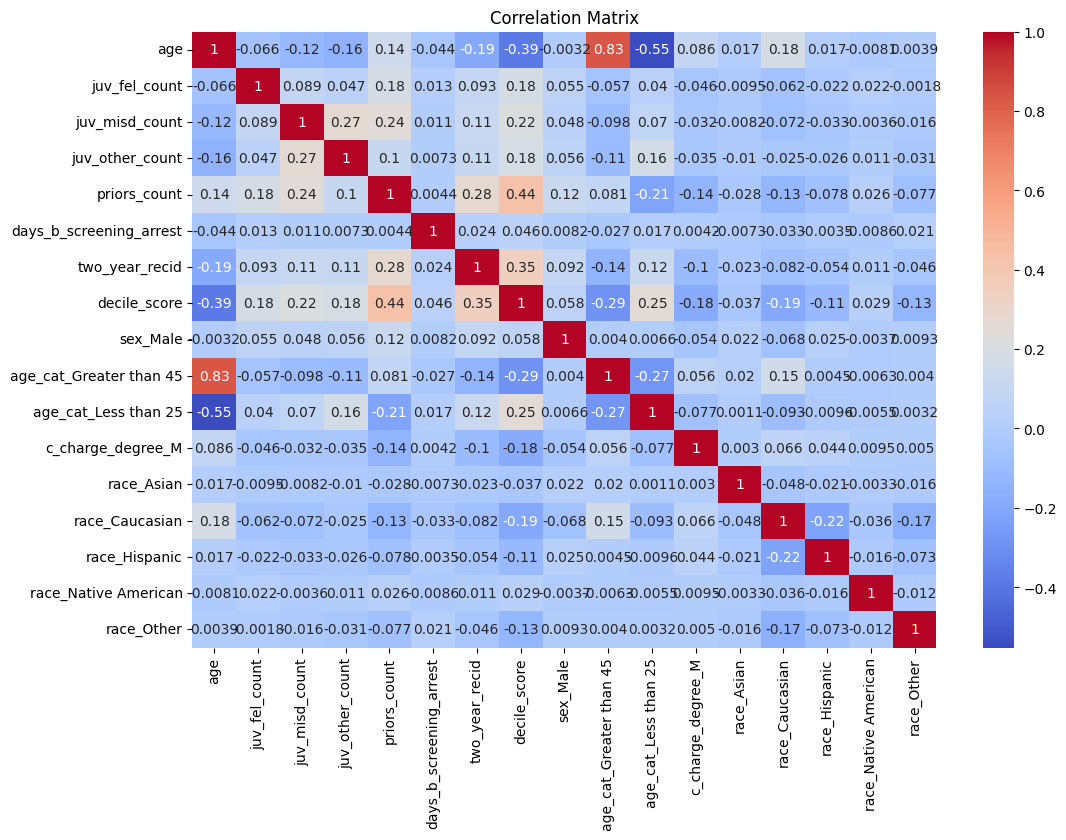

Duplicate Rows: 556
Cross Tabulation (Race vs Recidivism):
 two_year_recid           0         1
race                                
African-American  0.485660  0.514340
Asian             0.718750  0.281250
Caucasian         0.606357  0.393643
Hispanic          0.635793  0.364207
Native American   0.444444  0.555556
Other             0.647215  0.352785


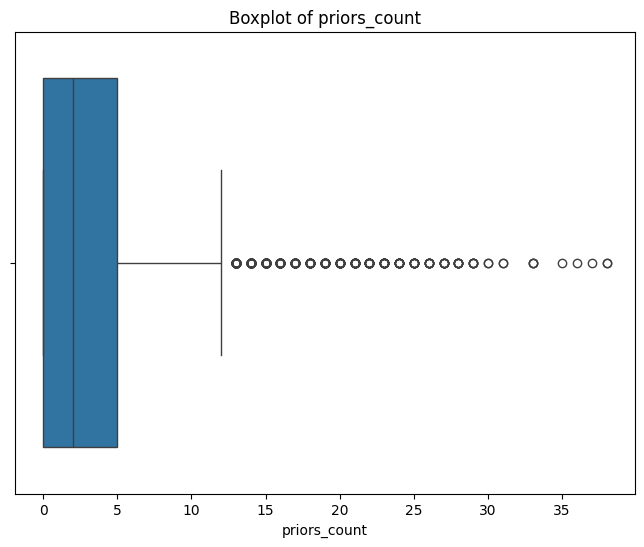

KeyError: 'year'

In [22]:
# 8. Class Distribution of the Label
print("Class Distribution (two_year_recid):\n", df['two_year_recid'].value_counts(normalize=True))

# 9. Correlation Matrix
correlation_matrix = df_analysis_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# 10. Data Type Conversions (Example for Date Fields)
df['compas_screening_date'] = pd.to_datetime(df['compas_screening_date'], errors='coerce')

# 11. Duplicate Rows
duplicates = df[df_analysis_encoded.duplicated()]
print("Duplicate Rows:", duplicates.shape[0])

# 12. Cross-Tabulation for Race and Recidivism
race_recid_ct = pd.crosstab(df['race'], df['two_year_recid'], normalize='index')
print("Cross Tabulation (Race vs Recidivism):\n", race_recid_ct)

# 13. Outliers (Box Plot for priors_count)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['priors_count'])
plt.title("Boxplot of priors_count")
plt.show()

# 14. Date-Based Analysis
df['year'] = df['compas_screening_date'].dt.year
recidivism_by_year = df_analysis.groupby('year')['two_year_recid'].mean()
plt.figure(figsize=(8, 6))
recidivism_by_year.plot(kind='bar')
plt.title("Recidivism Rate by Year")
plt.ylabel("Recidivism Rate")
plt.xlabel("Year")
plt.show()


In [ ]:
# 15. Distribution Analysis for Numerical Features
numerical_cols = df_analysis.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols].hist(figsize=(12, 10), bins=20)
plt.suptitle("Distributions of Numerical Features")
plt.show()

# 16. Feature Importance (Using Random Forest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Prepare dataset
X = df[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'c_charge_degree']]
X = pd.get_dummies(X, drop_first=True)  # Encode categorical variables
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

# 17. Bias Analysis: Error Rates Across Groups
from sklearn.metrics import confusion_matrix

y_pred = rf_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Group-Specific Analysis
for group in df['race'].unique():
    group_data = df[df['race'] == group]
    X_group = pd.get_dummies(group_data[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'c_charge_degree']], drop_first=True)
    y_group = group_data['two_year_recid']
    y_pred_group = rf_model.predict(X_group)
    group_conf_matrix = confusion_matrix(y_group, y_pred_group)
    print(f"Confusion Matrix for {group}:\n", group_conf_matrix)

# 18. ROC Curves
from sklearn.metrics import roc_curve, auc

y_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 19. Fairness Metrics
# Example: Calculate disparate impact ratio for race
positive_rate_by_race = df_analysis.groupby('race')['two_year_recid'].mean()
disparate_impact_ratio = positive_rate_by_race / positive_rate_by_race.max()
print("Disparate Impact Ratio:\n", disparate_impact_ratio)

# 20. Data Transformation for Modeling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled Data:\n", pd.DataFrame(X_scaled, columns=X.columns).head())
